In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# check GPU status
!nvidia-smi

Sun Feb  2 20:21:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:B7:00.0 Off |                    0 |
| N/A   38C    P0             61W /  400W |     115MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 1. load config
import json
config_fname = 'configs/ours-pretrain-diffusion-aligned-frames.json'
# config_fname = 'configs/ours-pretrain-diffusion-patchify-video.json'

config = json.load(open(config_fname))

In [5]:
check_dict(config)

data                                                         dict_keys(['DENSE_filenames', 'train_subject_exclude_patterns', 'val_subject_patterns', 'test_subject_patterns'])
datasets                                                     dict_keys(['train', 'val', 'test'])
networks                                                     dict_keys(['registration', 'latent'])
training                                                     dict_keys(['seed', 'scheme', 'batch_forward_method', 'reg_forward_data', 'regression_output_type', 'mask_padded_frames', 'resize_before_regression', 'batch_size', 'epochs', 'enable_random_rotate', 'random_rotate_prob_thres', 'epochs_without_improvement_tolerance', 'save_best_model_interval', 'training_latent_model_epoch_interval', 'training_motion_decoder_epoch_interval', 'optimization'])
losses                                                       dict_keys(['denoising'])
evaluation                                                   dict_keys(['noise_prediction_

In [6]:
from modules.data import glob_star
import json
import glob

def load_DENSE_data(DENSE_data_fnames):
    # Load raw data
    all_data_raw = []
    all_data_fnames = list(glob_star(DENSE_data_fnames))
    for all_data_fname in all_data_fnames:
        all_data_raw += np.load(all_data_fname, allow_pickle=True).tolist()
    
    # Keep only the necessary files
    all_data = []
    for datum_idx, datum_raw in enumerate(all_data_raw):
        loaded_datum = {}

        # loaded_datum = get_data_from_slice(datum_raw, data_to_feed)        
        loaded_datum['DENSE_disp'] = np.stack([datum_raw['DENSE_Lag_displacement_field_X'], datum_raw['DENSE_Lag_displacement_field_Y']], axis=0)
        loaded_datum['myo_masks'] = datum_raw['DENSE_myo_masks_rescaled']#[None]
        # loaded_datum['PositionA'] = datum_raw['AnalysisInfo']['PositionA']
        # loaded_datum['PositionB'] = datum_raw['AnalysisInfo']['PositionB']
        loaded_datum['slice_mat_filename'] = str(datum_raw.get('DENSE_slice_mat_filename', 'None'))
        loaded_datum['slice_location'] = float(datum_raw.get('DENSE_slice_location', -1e-3))
        
        loaded_datum['subject_id'] = datum_raw['patient_id']
        loaded_datum['slice_idx'] = datum_idx
        loaded_datum['slice_full_id'] = f'{datum_raw["patient_id"]}-{datum_idx}'
        loaded_datum['SequenceInfo'] = datum_raw['SequenceInfo']
        loaded_datum['ori_n_frames'] = loaded_datum['myo_masks'].shape[-1]

        all_data.append(loaded_datum)
    return all_data

all_data = load_DENSE_data(config['data']['DENSE_filenames'])

In [7]:
# 2. load all data splits
train_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') not in config['data']['train_subject_exclude_patterns']]
}
val_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['val_subject_patterns']]
}
test_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['test_subject_patterns']]
}

data_splits = {
    'train': train_split,
    'val': val_split,
    'test': test_split
}

In [8]:
check_dict(train_split['data'][0])

DENSE_disp                                                   (2, 48, 48, 22)     
myo_masks                                                    (128, 128, 22)      
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
SequenceInfo                                                 (2, 3)              
ori_n_frames                                                 22                  


In [9]:
# 4. Building dataset
from modules.data.dataset import build_datasets
datasets = build_datasets(data_splits, config['datasets'])
# print the length of each dataset
for dataset_name, dataset in datasets.items():
    print(f'{dataset_name} dataset length: {len(dataset)}')

Aligning displacement field frames to 41 frames
# of frames before alignment: [18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 75]
# of frames after alignment: [41]
Aligning displacement field frames to 41 frames
# of frames before alignment: [18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 75]
# of frames after alignment: [41]
Using Lagrangian displacement field
Aligning displacement field frames to 41 frames
# of frames before alignment: [65, 39, 41, 43, 45, 47, 49, 29, 51, 53, 24, 57, 59, 61, 25, 31]
# of frames after alignment: [41]
Aligning displacement field frames to 41 frames
# of frames before alignment: [65, 39, 41, 43, 45, 47, 49, 29, 51, 53, 24, 57, 59, 61, 25, 31]
# of frames after alignment: [41]
Using Lagrangian displacement field
Aligning displacement field frames to 41 frames
# of frames before alignment

In [10]:
check_dict(datasets['train'][0])

DENSE_disp                                                   (2, 40, 48, 48)     
src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
ori_n_frames                                                 22                  


In [11]:
check_dict(datasets['train'][-1])

DENSE_disp                                                   (2, 40, 48, 48)     
src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/dod_ya_ROI.3.mat
slice_location                                               -0.4107601991522    
subject_id                                                   dod_ya              
slice_idx                                                    740                 
slice_full_id                                                dod_ya-740          
ori_n_frames                                                 55                  


In [12]:
# 6. Building model
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to( device)
# model = build_model(config['network'])

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30


In [13]:
# Training
from modules.trainer import build_trainer
config['training']['epochs'] = 15 # set only 30 epochs for debugging
config['training']['batch_size'] = 32
config['training']['learning_rate'] = 1e-4
trainer = build_trainer(config['training'], device, config)

In [14]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

Loss denoising_error is disabled
latent lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f4338394b20>


17it [00:23,  1.40s/it]00:00<?, ?it/s]
4it [00:04,  1.12s/it].662e-02:   0%|          | 0/15 [00:23<?, ?it/s]
Epoch 0 | Train Loss 1.662e-02:   7%|▋         | 1/15 [00:28<06:38, 28.50s/it]

{
    "train/denoising": 0.04190197729450815,
    "train/total_loss": 0.0838039545890163,
    "train/noise_prediction_error": 0.04190197729450815,
    "val/denoising": 0.01841077022254467,
    "val/total_loss": 0.03682154044508934,
    "val/noise_prediction_error": 0.01841077022254467
}


17it [00:33,  1.95s/it]
4it [00:03,  1.15it/s].217e-02:   7%|▋         | 1/15 [01:01<06:38, 28.50s/it]
Epoch 1 | Train Loss 1.217e-02:  13%|█▎        | 2/15 [01:05<07:14, 33.40s/it]

{
    "train/denoising": 0.0154600055230891,
    "train/total_loss": 0.0309200110461782,
    "train/noise_prediction_error": 0.0154600055230891,
    "val/denoising": 0.013246399583294988,
    "val/total_loss": 0.026492799166589975,
    "val/noise_prediction_error": 0.013246399583294988
}


17it [00:31,  1.86s/it]
4it [00:06,  1.55s/it].071e-02:  13%|█▎        | 2/15 [01:37<07:14, 33.40s/it]
Epoch 2 | Train Loss 1.071e-02:  20%|██        | 3/15 [01:43<07:05, 35.50s/it]

{
    "train/denoising": 0.012504003339392297,
    "train/total_loss": 0.025008006678784594,
    "train/noise_prediction_error": 0.012504003339392297,
    "val/denoising": 0.010100561892613769,
    "val/total_loss": 0.020201123785227537,
    "val/noise_prediction_error": 0.010100561892613769
}


17it [00:31,  1.85s/it]
4it [00:04,  1.19s/it].249e-02:  20%|██        | 3/15 [02:14<07:05, 35.50s/it]
Epoch 3 | Train Loss 1.249e-02:  27%|██▋       | 4/15 [02:19<06:34, 35.85s/it]

{
    "train/denoising": 0.01123095490038395,
    "train/total_loss": 0.0224619098007679,
    "train/noise_prediction_error": 0.01123095490038395,
    "val/denoising": 0.009141511749476194,
    "val/total_loss": 0.01828302349895239,
    "val/noise_prediction_error": 0.009141511749476194
}


17it [00:18,  1.09s/it]
4it [00:05,  1.33s/it].392e-03:  27%|██▋       | 4/15 [02:38<06:34, 35.85s/it]
Epoch 4 | Train Loss 8.392e-03:  33%|███▎      | 5/15 [02:43<05:15, 31.56s/it]

{
    "train/denoising": 0.009507361333817244,
    "train/total_loss": 0.019014722667634487,
    "train/noise_prediction_error": 0.009507361333817244,
    "val/denoising": 0.007905427715741098,
    "val/total_loss": 0.015810855431482196,
    "val/noise_prediction_error": 0.007905427715741098
}


17it [00:14,  1.19it/s]
4it [00:02,  1.80it/s].969e-03:  33%|███▎      | 5/15 [02:58<05:15, 31.56s/it]
Epoch 5 | Train Loss 7.969e-03:  40%|████      | 6/15 [03:00<03:58, 26.51s/it]

{
    "train/denoising": 0.007898563875214142,
    "train/total_loss": 0.015797127750428283,
    "train/noise_prediction_error": 0.007898563875214142,
    "val/denoising": 0.006690972135402262,
    "val/total_loss": 0.013381944270804524,
    "val/noise_prediction_error": 0.006690972135402262
}


17it [00:15,  1.11it/s]
4it [00:02,  1.84it/s].050e-03:  40%|████      | 6/15 [03:15<03:58, 26.51s/it]
Epoch 6 | Train Loss 7.050e-03:  47%|████▋     | 7/15 [03:17<03:08, 23.61s/it]

{
    "train/denoising": 0.00727559656233472,
    "train/total_loss": 0.01455119312466944,
    "train/noise_prediction_error": 0.00727559656233472,
    "val/denoising": 0.007095815613865852,
    "val/total_loss": 0.014191631227731705,
    "val/noise_prediction_error": 0.007095815613865852
}
Epochs without improvement: 1 / 30


17it [00:14,  1.18it/s]
4it [00:02,  1.86it/s].548e-03:  47%|████▋     | 7/15 [03:32<03:08, 23.61s/it]
Epoch 7 | Train Loss 6.548e-03:  53%|█████▎    | 8/15 [03:34<02:29, 21.42s/it]

{
    "train/denoising": 0.006833683288491824,
    "train/total_loss": 0.013667366576983649,
    "train/noise_prediction_error": 0.006833683288491824,
    "val/denoising": 0.0060003818944096565,
    "val/total_loss": 0.012000763788819313,
    "val/noise_prediction_error": 0.0060003818944096565
}


17it [00:14,  1.16it/s]
4it [00:02,  1.88it/s].744e-03:  53%|█████▎    | 8/15 [03:49<02:29, 21.42s/it]
Epoch 8 | Train Loss 8.744e-03:  60%|██████    | 9/15 [03:51<02:00, 20.02s/it]

{
    "train/denoising": 0.006634644013555611,
    "train/total_loss": 0.013269288027111222,
    "train/noise_prediction_error": 0.006634644013555611,
    "val/denoising": 0.006074316333979368,
    "val/total_loss": 0.012148632667958736,
    "val/noise_prediction_error": 0.006074316333979368
}
Epochs without improvement: 1 / 30


17it [00:14,  1.19it/s]
4it [00:02,  1.70it/s].434e-03:  60%|██████    | 9/15 [04:06<02:00, 20.02s/it]
Epoch 9 | Train Loss 5.434e-03:  67%|██████▋   | 10/15 [04:08<01:35, 19.04s/it]

{
    "train/denoising": 0.006445846410796922,
    "train/total_loss": 0.012891692821593845,
    "train/noise_prediction_error": 0.006445846410796922,
    "val/denoising": 0.005632195272482932,
    "val/total_loss": 0.011264390544965863,
    "val/noise_prediction_error": 0.005632195272482932
}


17it [00:17,  1.05s/it]
4it [00:02,  1.82it/s]6.741e-03:  67%|██████▋   | 10/15 [04:26<01:35, 19.04s/it]
Epoch 10 | Train Loss 6.741e-03:  73%|███████▎  | 11/15 [04:28<01:17, 19.39s/it]

{
    "train/denoising": 0.006234922692837084,
    "train/total_loss": 0.012469845385674168,
    "train/noise_prediction_error": 0.006234922692837084,
    "val/denoising": 0.006509354338049889,
    "val/total_loss": 0.013018708676099777,
    "val/noise_prediction_error": 0.006509354338049889
}
Epochs without improvement: 1 / 30


17it [00:14,  1.19it/s]
4it [00:02,  1.87it/s]5.882e-03:  73%|███████▎  | 11/15 [04:43<01:17, 19.39s/it]
Epoch 11 | Train Loss 5.882e-03:  80%|████████  | 12/15 [04:45<00:55, 18.54s/it]

{
    "train/denoising": 0.0060286732554874,
    "train/total_loss": 0.0120573465109748,
    "train/noise_prediction_error": 0.0060286732554874,
    "val/denoising": 0.0069559181574732065,
    "val/total_loss": 0.013911836314946413,
    "val/noise_prediction_error": 0.0069559181574732065
}
Epochs without improvement: 2 / 30


17it [00:16,  1.04it/s]
4it [00:02,  1.43it/s]5.156e-03:  80%|████████  | 12/15 [05:01<00:55, 18.54s/it]
Epoch 12 | Train Loss 5.156e-03:  87%|████████▋ | 13/15 [05:04<00:37, 18.76s/it]

{
    "train/denoising": 0.0057401949649347975,
    "train/total_loss": 0.011480389929869595,
    "train/noise_prediction_error": 0.0057401949649347975,
    "val/denoising": 0.005750576034188271,
    "val/total_loss": 0.011501152068376541,
    "val/noise_prediction_error": 0.005750576034188271
}
Epochs without improvement: 3 / 30


17it [00:16,  1.05it/s]
4it [00:02,  1.91it/s]5.616e-03:  87%|████████▋ | 13/15 [05:20<00:37, 18.76s/it]
Epoch 13 | Train Loss 5.616e-03:  93%|█████████▎| 14/15 [05:22<00:18, 18.65s/it]

{
    "train/denoising": 0.005873356754069819,
    "train/total_loss": 0.011746713508139639,
    "train/noise_prediction_error": 0.005873356754069819,
    "val/denoising": 0.005522385006770492,
    "val/total_loss": 0.011044770013540983,
    "val/noise_prediction_error": 0.005522385006770492
}


17it [00:14,  1.19it/s]
4it [00:05,  1.44s/it]5.271e-03:  93%|█████████▎| 14/15 [05:37<00:18, 18.65s/it]
Epoch 14 | Train Loss 5.271e-03: 100%|██████████| 15/15 [05:43<00:00, 22.88s/it]

{
    "train/denoising": 0.005769018878174179,
    "train/total_loss": 0.011538037756348358,
    "train/noise_prediction_error": 0.005769018878174179,
    "val/denoising": 0.006103461142629385,
    "val/total_loss": 0.01220692228525877,
    "val/noise_prediction_error": 0.006103461142629385
}
Epochs without improvement: 1 / 30


In [15]:
# generate training set prediction
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/denoising': 0.006161861779058681, 'train/total_loss': 0.012323723558117361, 'train/noise_prediction_error': 0.006161861779058681}


In [16]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/denoising': 0.006511055282317102, 'test/total_loss': 0.013022110564634204, 'test/noise_prediction_error': 0.006511055282317102}


In [17]:
check_dict(test_pred[0])

latent_pred                                                  (16, 40, 16, 16)    
reg_disp_pred                                                None                
noise_pred                                                   (16, 40, 16, 16)    
DENSE_disp                                                   (2, 40, 48, 48)     
src                                                          (1, 40, 128, 128)   
tar                                                          (1, 40, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
slice_location                                               76.947609505431     
subject_id                                                   033                 
slice_idx                                                    31                  
slice_full_id                                                033-31              
ori_n_frames           

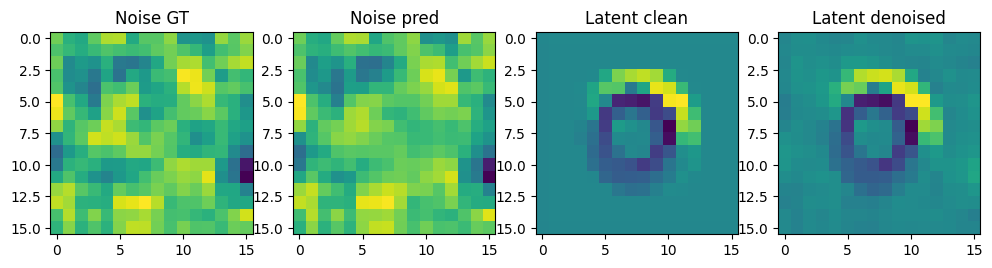

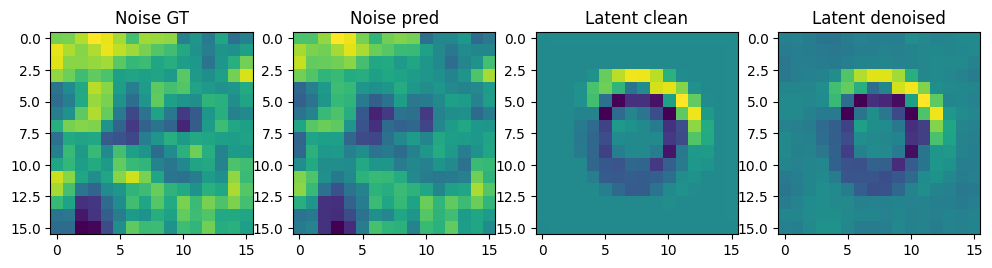

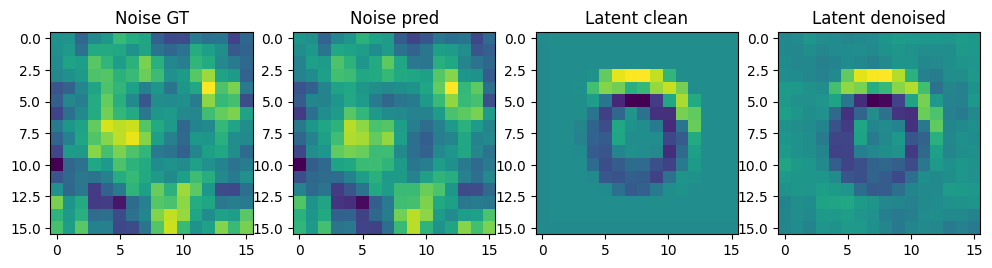

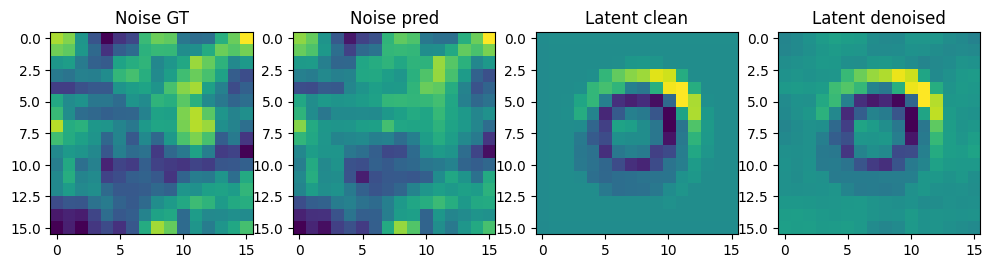

In [18]:
vis_frame = 8
for vis_datum_idx in [0,5,10,20]:
    vis_datum = train_pred[vis_datum_idx]
    vis_noise_GT = vis_datum['noise'][0, vis_frame]
    vis_noise_pred = vis_datum['noise_pred'][0, vis_frame]
    vis_latent_clean = vis_datum['latent'][0, vis_frame]
    vis_latent_denoised = vis_datum['latent_pred'][0, vis_frame]

    fig, axs = plt.subplots(1,4, figsize=(12, 3))
    axs[0].imshow(vis_noise_GT)
    axs[0].set_title('Noise GT')
    axs[1].imshow(vis_noise_pred)
    axs[1].set_title('Noise pred')
    axs[2].imshow(vis_latent_clean)
    axs[2].set_title('Latent clean')
    axs[3].imshow(vis_latent_denoised)
    axs[3].set_title('Latent denoised')

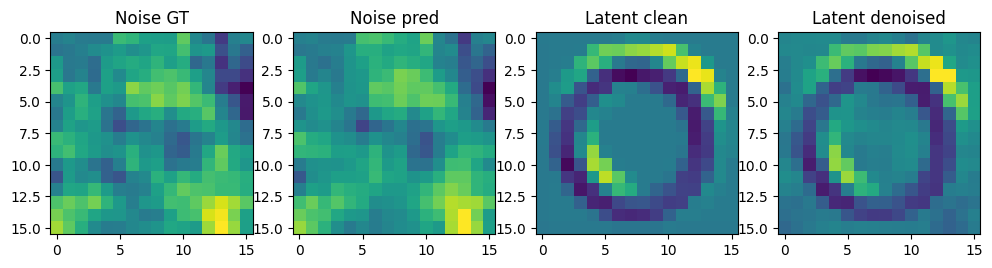

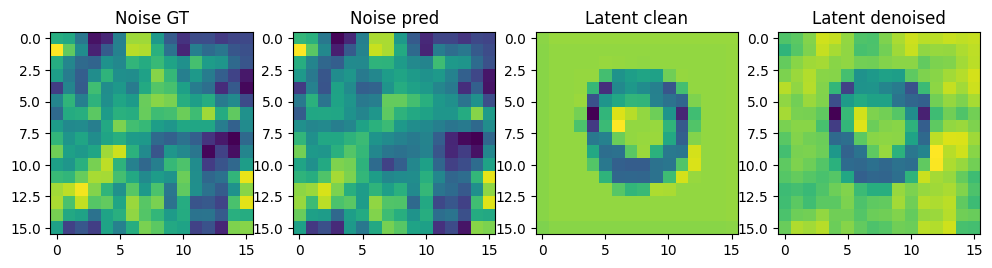

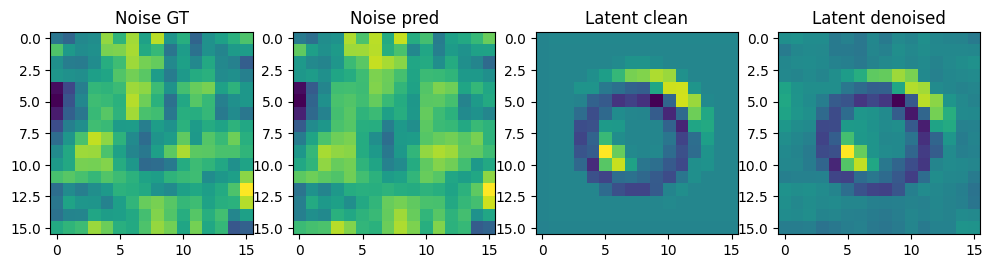

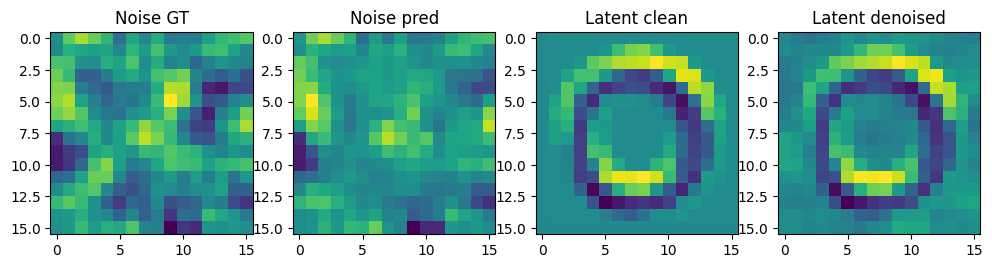

In [19]:
vis_frame = 8
for vis_datum_idx in [0,5,10,20]:
    vis_datum = test_pred[vis_datum_idx]
    vis_noise_GT = vis_datum['noise'][0, vis_frame]
    vis_noise_pred = vis_datum['noise_pred'][0, vis_frame]
    vis_latent_clean = vis_datum['latent'][0, vis_frame]
    vis_latent_denoised = vis_datum['latent_pred'][0, vis_frame]

    fig, axs = plt.subplots(1,4, figsize=(12, 3))
    axs[0].imshow(vis_noise_GT)
    axs[0].set_title('Noise GT')
    axs[1].imshow(vis_noise_pred)
    axs[1].set_title('Noise pred')
    axs[2].imshow(vis_latent_clean)
    axs[2].set_title('Latent clean')
    axs[3].imshow(vis_latent_denoised)
    axs[3].set_title('Latent denoised')